In [1]:
import numpy as np
import scipy
from scipy.io import wavfile
import six
import tensorflow as tf
import vggish_input
import vggish_params as params
import vggish_slim
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
CONTENT = vggish_input.wavfile_to_examples('Content.wav')
STYLE = vggish_input.wavfile_to_examples('Style.wav')

(441216, 2) 44100
(441000, 2) 44100


In [3]:
def plot_spec(spec,title):    
    plt.imshow(spec.T)
    plt.title(title)

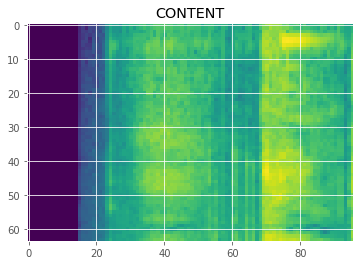

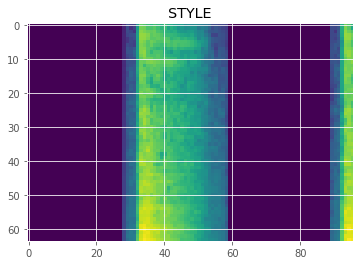

In [4]:
fig = plt.figure(1)
plot_spec(CONTENT[0],'CONTENT')
fig.savefig('Content.png')
fig = plt.figure(2)
plot_spec(STYLE[0],'STYLE')
fig.savefig('Style.png')
plt.show()

In [5]:
with tf.Graph().as_default(),tf.Session() as sess:
    vggish_slim.define_vggish_slim(training=False)
    vggish_slim.load_vggish_slim_checkpoint(sess, 'vggish_model.ckpt')
    features_tensor = sess.graph.get_tensor_by_name(params.INPUT_TENSOR_NAME)

    FIRST_CONTENT = sess.run(sess.graph.get_tensor_by_name(params.FIRST_BIAS),{features_tensor:CONTENT})
    SECOND_CONTENT = sess.run(sess.graph.get_tensor_by_name(params.SECOND_BIAS),{features_tensor:CONTENT})
    THIRD_CONTENT = sess.run(sess.graph.get_tensor_by_name(params.THIRD_BIAS),{features_tensor:CONTENT})
    FOURTH_CONTENT = sess.run(sess.graph.get_tensor_by_name(params.FOURTH_BIAS),{features_tensor:CONTENT})
    FIFTH_CONTENT = sess.run(sess.graph.get_tensor_by_name(params.FIFTH_BIAS),{features_tensor:CONTENT})
    SIXTH_CONTENT = sess.run(sess.graph.get_tensor_by_name(params.SIXTH_BIAS),{features_tensor:CONTENT})

    FIRST_STYLE = sess.run(sess.graph.get_tensor_by_name(params.FIRST_BIAS),{features_tensor:STYLE})
    SECOND_STYLE = sess.run(sess.graph.get_tensor_by_name(params.SECOND_BIAS),{features_tensor:STYLE})
    THIRD_STYLE = sess.run(sess.graph.get_tensor_by_name(params.THIRD_BIAS),{features_tensor:STYLE})
    FOURTH_STYLE = sess.run(sess.graph.get_tensor_by_name(params.FOURTH_BIAS),{features_tensor:STYLE})
    FIFTH_STYLE = sess.run(sess.graph.get_tensor_by_name(params.FIFTH_BIAS),{features_tensor:STYLE})
    SIXTH_STYLE = sess.run(sess.graph.get_tensor_by_name(params.SIXTH_BIAS),{features_tensor:STYLE})

INFO:tensorflow:Restoring parameters from vggish_model.ckpt


In [6]:
LAYER = {}
LAYER[1] = params.FIRST_BIAS
LAYER[2] = params.SECOND_BIAS
LAYER[3] = params.THIRD_BIAS
LAYER[4] = params.FOURTH_BIAS
LAYER[5] = params.FIFTH_BIAS
LAYER[6] = params.SIXTH_BIAS

In [7]:
def content_loss(content,content_layer,session):
    mixed = session.graph.get_tensor_by_name(LAYER[content_layer])
    return tf.reduce_sum((mixed-content)**2)/content.size

In [8]:
def gram_matrix(matrix):
    _,wid,hei,num = map(lambda i:i.value,matrix.get_shape())
    size = wid*hei
    matrix = tf.reshape(matrix,[-1,num])
    gram = tf.transpose(matrix)@matrix/size
    return gram

In [9]:
def style_loss(style,style_layer,session):
    mixed = session.graph.get_tensor_by_name(LAYER[style_layer])
    shape = style.shape
    style_gram = np.reshape(style,[-1,shape[-1]])
    style_gram = style_gram.T@style_gram/(shape[0]*shape[1])
    return tf.reduce_sum((gram_matrix(mixed)-style_gram)**2)/style_gram.size

In [10]:
def total_loss(content_weight,style_weight,content,style,content_layer,style_layer,session):
    return content_weight*content_loss(content,content_layer,session)+ style_weight*style_loss(style,style_layer,session)

In [11]:
mix = np.random.randn(*CONTENT.shape)

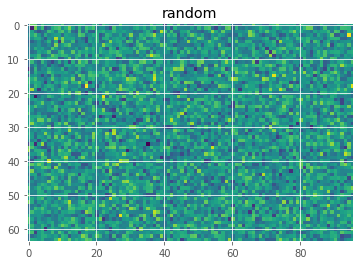

In [12]:
fig = plt.figure()
plot_spec(mix[0],'random')
fig.savefig('random.png')
plt.show()

In [13]:
result_dict = {}

INFO:tensorflow:Restoring parameters from vggish_model.ckpt


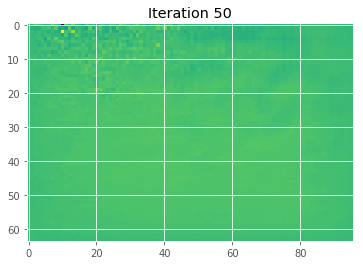

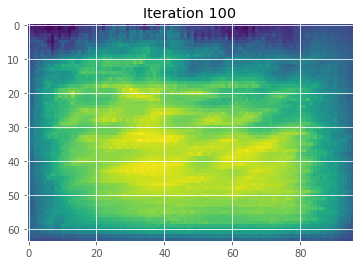

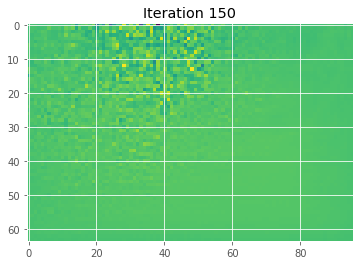

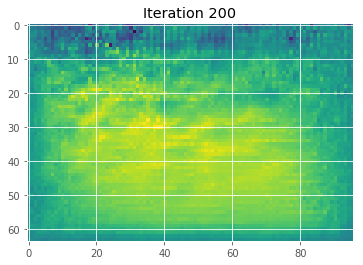

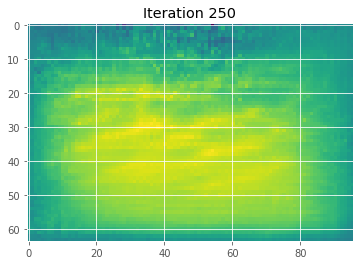

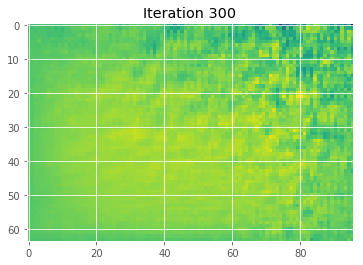

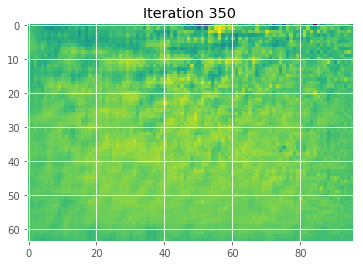

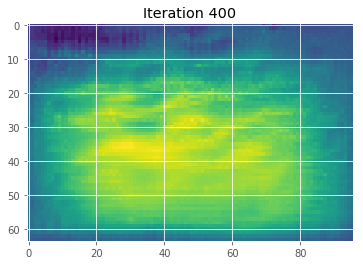

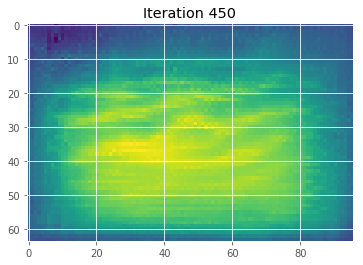

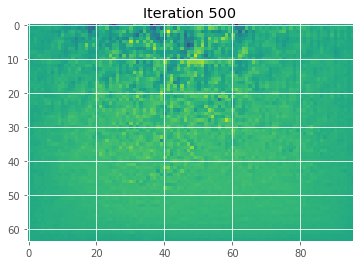

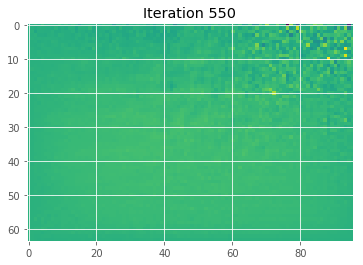

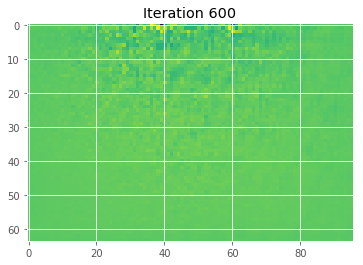

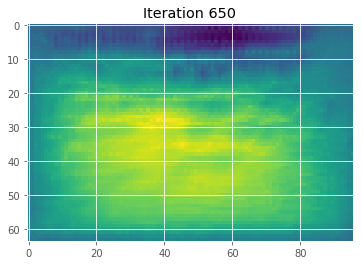

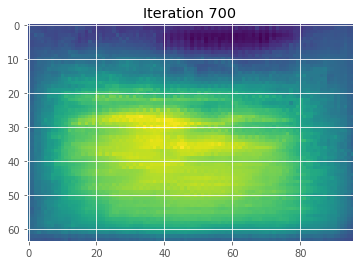

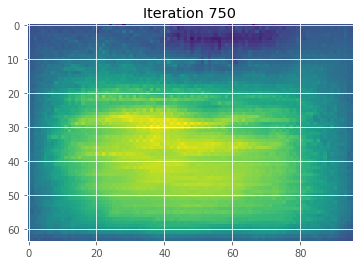

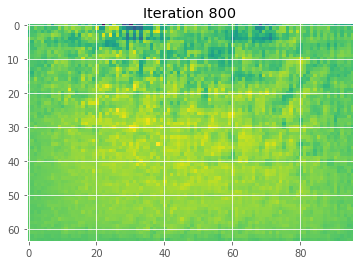

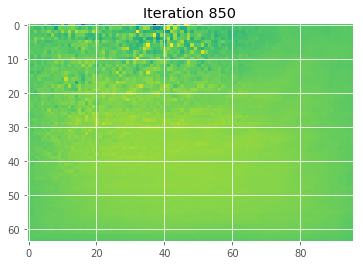

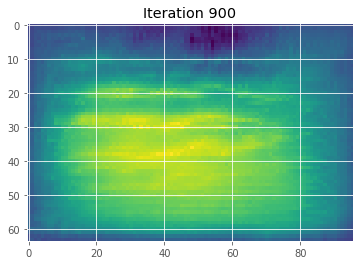

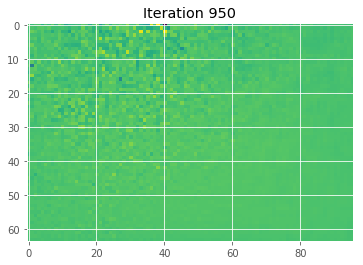

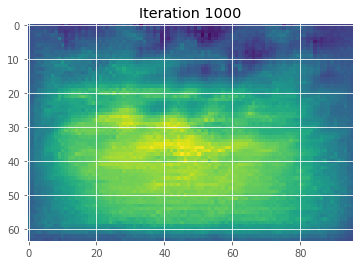

In [16]:
with tf.Graph().as_default(),tf.Session() as sess:
    vggish_slim.define_vggish_slim(training=False)
    vggish_slim.load_vggish_slim_checkpoint(sess, 'vggish_model.ckpt')
    features_tensor = sess.graph.get_tensor_by_name(params.INPUT_TENSOR_NAME)

    final_loss = total_loss(10,1.5,FIFTH_CONTENT,FIRST_STYLE,5,1,sess)    
    
    gradient = tf.gradients(final_loss,features_tensor)

    loss = []
    for i in range(1000):
        if (i+1)%50==0:
            fig = plt.figure()
            plot_spec(mix[0],'Iteration '+str(i+1))
            fig.savefig('Iteration '+str(i+1)+'.png')
        grad = sess.run(gradient,{features_tensor:mix})
        grad = np.squeeze(grad)
        step_size_scaled = 10.0 / (np.std(grad) + 1e-8)
        mix -= grad* step_size_scaled
        result_dict[i+1]=mix
        loss.append(sess.run(final_loss,{features_tensor:mix}))

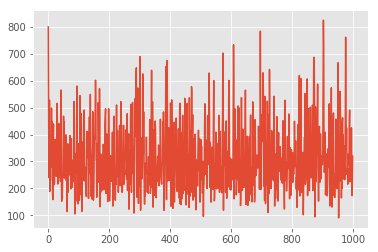

In [17]:
fig = plt.figure(3)
plt.plot(np.arange(1000),loss)
fig.savefig('Loss_content_5.png')

In [18]:
np.argmin(loss)

953

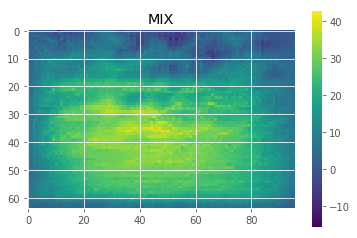

In [20]:
fig = plt.figure(4)
plot_spec(mix[0],'MIX')
plt.colorbar()
fig.savefig('Content_5.png')

In [21]:
import pickle
f = open("Content_5.pkl","wb")
pickle.dump(result_dict,f)
f.close()

In [27]:
obj = pickle.load(open("Content_5.pkl", "rb"))

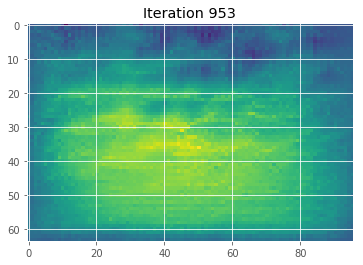

In [28]:
fig = plt.figure()
plot_spec(obj[953][0],'Iteration 953')
plt.show()